In [1]:
import os
import itertools
import tempfile
import warnings
import pandas as pd
import qiime2 as q2
import numpy as np
from scipy.stats import ttest_ind
from biom import load_table, Table

from skbio import TreeNode
from skbio import OrdinationResults
from skbio.stats.distance import permanova
from skbio.stats.distance import mantel
from skbio.stats.distance import DistanceMatrix
from qiime2.plugins.deicode.actions import (rpca,
                                            auto_rpca)
from qiime2.plugins.emperor.actions import biplot
from qiime2.plugins.qurro.actions import (loading_plot,
                                          differential_plot,
                                          qarcoal)
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from assets.step_wise_anova import run_stepwise_anova
from qiime2.plugins.diversity.actions import beta_group_significance
from qiime2.plugins.feature_table.actions import filter_features

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
%matplotlib inline

In [2]:

def pairwise_ttest(df, group_column, value,
                   combinations=[],
                   correction=True):

    # get combos
    if len(combinations) == 0:
        order = sorted(set(df[group_column]))
        combinations = itertools.combinations(order, 2)
        combinations = list(combinations)
    pairwisedf = []
    max_order = {}
    for c1, c2 in combinations:
        # t-test
        t1 = df[df[group_column].isin([c1])][value].values
        t2 = df[df[group_column].isin([c2])][value].values
        t_res = ttest_ind(t1, t2)   
        # tdf
        t_res = pd.DataFrame(t_res,
                             ['test-stat','P'],
                             [c1 + ' vs. ' + c2])
        pairwisedf.append(t_res)
        max_= max(max(t1),max(t2))
        max_order[c1 + ' vs. ' + c2] = max_
    # merge
    pairwisedf = pd.concat(pairwisedf, axis=1).T
    # bonfer correct
    if correction:
        pairwisedf['P'] = pairwisedf['P'] * len(combinations)
    else:
        pairwisedf['P'] = pairwisedf['P']
    return pairwisedf, max_order



def swarmbox_plot_hue(df, ax, y, x, hue, order,
                      hue_order, palette='Set1'):
    
    # plotting.
    sns.swarmplot(y=y, x=x,
                  hue = hue,
                  dodge=True,
                  data=df,
                  hue_order=hue_order,
                  palette=palette,
                  order=order,
                  ax=ax, s=5)
    sns.boxplot(y=y, x=x,
                hue=hue,
                data=df,
                hue_order=hue_order,
                order=order,
                ax=ax,
                palette=palette)
    # patches
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    # title etc ... 
    ax.set_xlabel('', fontsize=25)
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
    ax.tick_params(axis='x', colors='black')
    
    return ax


### all-data

In [3]:
# import data
table = q2.Artifact.load('../data/16S/10849-only-table.qza')
metadata = q2.Metadata.load('../data/16S/10849-only-metadata.qza')
taxonomy = q2.Metadata.load('../data/16S/all-taxonomy.qza')
tree = q2.Artifact.load('../data/16S/insertion-tree.qza')


In [4]:
filt_table = filter_features(table, min_frequency=10).filtered_table
uwnuni = beta_phylogenetic(filt_table, tree,
                           'unweighted_unifrac')
wuni = beta_phylogenetic(filt_table, tree,
                         'weighted_unifrac')
rpca_res = rpca(filt_table)


In [5]:
# make metadata catagories
mf = metadata.to_dataframe()
mf['Sample-Type'] = mf['jpl_controltype_0_1'].replace({'0':'Rooms','1':'Controls'})
mf['PMA-Treatment'] = mf['jpl_pma'].replace({'FALSE':'No-PMA','TRUE':'PMA'})
mf['pairwise-test'] = mf['Sample-Type'] + ':' + mf['PMA-Treatment']
perm_meta = q2.Metadata(mf)
pairwise_all = {}
for id_, dist_ in {'weighted UniFrac':wuni,
             'unweighted UniFrac':uwnuni,
             'Aitchison':rpca_res}.items():
    # save all intermediate files into tmp dir
    with tempfile.TemporaryDirectory() as temp_dir_name:

        res_ = beta_group_significance(dist_.distance_matrix,
                                       perm_meta.get_column('pairwise-test'),
                                       pairwise=True)
        res_.visualization.export_data(temp_dir_name)
        res_df = pd.read_csv(os.path.join(temp_dir_name,
                                          'permanova-pairwise.csv'))
        pairwise_all[id_] = res_df 
pairwise_df = pd.concat(pairwise_all)
pairwise_df = pairwise_df.reset_index().set_index(['level_0', 'Group 1', 'Group 2'])
pairwise_df = pairwise_df.drop(['level_1'], axis=1)
pairwise_df.index.names = ['Metric','Group 1','Group 2']
pairwise_df.to_csv('../results/tables/pairwise-pma-control.tsv', sep='\t')
pairwise_df


Sample size  Permutations  \
Metric             Group 1         Group 2                                   
weighted UniFrac   Controls:No-PMA Controls:PMA           35           999   
                                   Rooms:No-PMA          120           999   
                                   Rooms:PMA             119           999   
                   Controls:PMA    Rooms:No-PMA          111           999   
                                   Rooms:PMA             110           999   
                   Rooms:No-PMA    Rooms:PMA             195           999   
unweighted UniFrac Controls:No-PMA Controls:PMA           35           999   
                                   Rooms:No-PMA          120           999   
                                   Rooms:PMA             119           999   
                   Controls:PMA    Rooms:No-PMA          111           999   
                                   Rooms:PMA             110           999   
                   Rooms:No-PMA    Rooms:PMA             195           999   
Aitchison          Controls:No-PMA Controls:PMA           35           999   
                                   Rooms:No-PMA          120           999   
                                   Rooms:PMA             119           999   
                   Controls:PMA    Rooms:No-PMA          111           999   
                                   Rooms:PMA             110           999   
                   Rooms:No-PMA    Rooms:PMA             195           999   

                                                  pseudo-F  p-value  q-value  
Metric             Group 1         Group 2                                    
weighted UniFrac   Controls:No-PMA Controls:PMA   1.064465    0.362   0.3620  
                                   Rooms:No-PMA  26.010102    0.001   0.0020  
                                   Rooms:PMA      1.329064    0.189   0.2835  
                   Controls:PMA    Rooms:No-PMA  18.670235    0.001   0.0020  
                                   Rooms:PMA      0.982720    0.325   0.3620  
                   Rooms:No-PMA    Rooms:PMA     78.510681    0.001   0.0020  
unweighted UniFrac Controls:No-PMA Controls:PMA   1.115284    0.269   0.2690  
                                   Rooms:No-PMA  16.569851    0.001   0.0020  
                                   Rooms:PMA      1.231521    0.138   0.1656  
                   Controls:PMA    Rooms:No-PMA  13.137584    0.001   0.0020  
                                   Rooms:PMA      1.491517    0.056   0.0840  
                   Rooms:No-PMA    Rooms:PMA     42.885851    0.001   0.0020  
Aitchison          Controls:No-PMA Controls:PMA   0.176498    0.900   0.9000  
                                   Rooms:No-PMA  36.705403    0.001   0.0020  
                                   Rooms:PMA      0.706619    0.462   0.6930  
                   Controls:PMA    Rooms:No-PMA  25.111286    0.001   0.0020  
                                   Rooms:PMA      0.420078    0.646   0.7752  
                   Rooms:No-PMA    Rooms:PMA     79.158277    0.001   0.0020

<Figure size 432x288 with 0 Axes>

In [6]:
# make metadata catagories
mf = metadata.to_dataframe()
mf['Sample-Type'] = mf['jpl_controltype_0_1'].replace({'0':'Rooms','1':'Controls'})
mf['PMA-Treatment'] = mf['jpl_pma'].replace({'FALSE':'No-PMA','TRUE':'PMA'})
mf['pairwise-test'] = mf['Sample-Type'] + ':' + mf['PMA-Treatment']
perm_meta = q2.Metadata(mf)
pairwise_time =[]
for id_, dist_ in {'weighted UniFrac':wuni,
             'unweighted UniFrac':uwnuni,
             'Aitchison':rpca_res}.items():
    res_ = pd.DataFrame(permanova(dist_.distance_matrix.view(DistanceMatrix),
                           perm_meta.to_dataframe()['collection_timestamp'])).T[['sample size','number of groups',
                                                                                 'test statistic','p-value']]
    res_.index = [id_]
    pairwise_time.append(res_)
pairwise_time_df = pd.concat(pairwise_time)
pairwise_time_df.to_csv('../results/tables/collection-timestamp-permanova.tsv', sep='\t')
pairwise_time_df

,sample size,number of groups,test statistic,p-value
weighted UniFrac,230,11,2.78162,0.001
unweighted UniFrac,230,11,1.93359,0.001
Aitchison,230,11,2.71027,0.001


In [8]:
# make metadata catagories
es_meta = metadata.to_dataframe()
es_meta = es_meta.fillna('unknown')
not_use =['qpcr_16scopies_per_ul', 'row_', 'sample_type',
          'BarcodeSequence', 'column_', 'other_thing','well_id',
          'anonymized_name', 'orig_name', 'Description']
es_meta = es_meta.drop(not_use, axis=1)
use = [c for c in es_meta.columns 
       if len(es_meta[c].unique()) > 1]
es_all = {}
for id_, ord_ in {'weighted UniFrac':pcoa(wuni.distance_matrix).pcoa.view(OrdinationResults).samples,
             'unweighted UniFrac':pcoa(uwnuni.distance_matrix).pcoa.view(OrdinationResults).samples,
             'Aitchison':rpca_res.biplot.view(OrdinationResults).samples}.items():
    esdf = run_stepwise_anova(ord_, es_meta.copy(), use)
    es_all[id_] = esdf
es_df = pd.concat(es_all)
es_df.index.names = ['Metric','metadata-catagory']
es_df.to_csv('../results/tables/effectsize-pma.tsv', sep='\t')
es_df  

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/bin/SAF-PP-JPL/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpuva0aoo5/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpuva0aoo5/mf_.txt /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpuva0aoo5/output.effect.size.tsv

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/bin/SAF-PP-JPL/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp74r9mbfn/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp74r9mbfn/mf_.txt /var/folders/tt/zz8

R2.adj    Df          AIC  \
Metric             metadata-catagory                                     
weighted UniFrac   + collection_timestamp  0.009463  10.0  1099.875782   
                   + jpl_location_area     0.005448  15.0  1112.288416   
                   + jpl_pma               0.003265   1.0  1112.394604   
                   <All variables>         0.002652   NaN          NaN   
unweighted UniFrac + collection_timestamp  0.002166  10.0  1220.648227   
                   <All variables>         0.001121   NaN          NaN   
Aitchison          + jpl_pma               0.139653   1.0   220.075667   
                   + jpl_location_area     0.063596  15.0   216.760709   
                   + collection_timestamp  0.048033  10.0   211.399434   
                   + host_subject_id       0.024497   9.0   211.318162   
                   <All variables>         0.000347   NaN          NaN   

                                                   F  Pr(>F)  
Metric             metadata-catagory                          
weighted UniFrac   + collection_timestamp   1.218774   0.002  
                   + jpl_location_area      1.080743   0.002  
                   + jpl_pma                1.678396   0.002  
                   <All variables>               NaN     NaN  
unweighted UniFrac + collection_timestamp   1.049714   0.002  
                   <All variables>               NaN     NaN  
Aitchison          + jpl_pma               38.171594   0.002  
                   + jpl_location_area      2.213261   0.002  
                   + collection_timestamp   2.366483   0.004  
                   + host_subject_id        1.762962   0.026  
                   <All variables>               NaN     NaN

### plot- PMA/-PMA

In [9]:
# rpca
rpca_res = rpca(table,
                min_feature_frequency=10)
# save it
for id_, art_ in rpca_res.__dict__.items():
    if id_ != '_fields':
        art_.save(os.path.join('../results/intermediates',
                               'all-%s' % (id_.replace('_', '-')) ))
emp_vis = biplot(rpca_res.biplot, metadata,
                 number_of_features=30,
                 feature_metadata=taxonomy)
emp_vis.visualization.save('../results/intermediates/all-biplot.qzv')
q2qurro = loading_plot(rpca_res.biplot, table, metadata,
                       feature_metadata=taxonomy)
q2qurro.visualization.save('../results/intermediates/all-qurro-loading.qzv')


30933 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.


'../results/intermediates/all-qurro-loading.qzv'

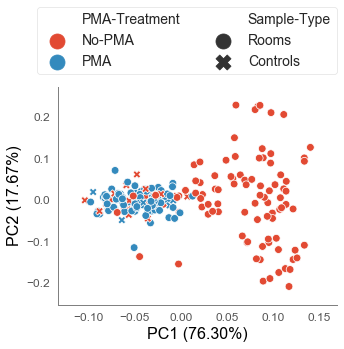

In [10]:
ord_plot = rpca_res.biplot.view(OrdinationResults)
ord_plot_samples = ord_plot.samples
p = ord_plot.proportion_explained
pc_cols = ['PC%i'%(i+1) for i in ord_plot_samples.columns]
ord_plot_samples.columns = pc_cols
ord_plot_samples = pd.concat([ord_plot_samples, metadata.to_dataframe()],axis=1)
ord_plot_samples['Sample-Type'] = ord_plot_samples['jpl_controltype_0_1'].replace({'0':'Rooms',
                                                                                   '1':'Controls'})
ord_plot_samples['PMA-Treatment'] = ord_plot_samples['jpl_pma'].replace({'FALSE':'No-PMA',
                                                                         'TRUE':'PMA'})

plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 5}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


fig, ax = plt.subplots(1,1, figsize=(5,4))

axis_1 = 'PC1'
axis_2 = 'PC2'

sns.scatterplot(x=axis_1,y=axis_2,
                hue='PMA-Treatment',
                style='Sample-Type',
                s=60,
                ax=ax,
                data=ord_plot_samples)


# Hide grid lines
ax.grid(False)
ax.set_facecolor('#f0f0f0')

# get axis labels
ax.set_xlabel('%s (%.2f%%)' %\
          (axis_1, p.loc[list(pc_cols).index(axis_1)] * 100),
         fontsize=16, color='#000000')
ax.set_ylabel('%s (%.2f%%)' %\
          (axis_2, p.loc[list(pc_cols).index(axis_2)] * 100),
         fontsize=16, color='#000000')

# remove all grids, backrounds etc ...
ax.legend_.remove()        
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_bounds(min_x, max_x)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')
        
        
# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:], labels[:], loc=2, 
                         bbox_to_anchor=(-0.10, 1.4),
                         prop={'size':14},
                         fancybox=True, framealpha=0.5, 
                         ncol=2, markerscale=3,
                         facecolor="white")

# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)


# save the figure to file
plt.savefig('../results/figures/pma-pcoa.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()



In [11]:
permanova(rpca_res.distance_matrix.view(DistanceMatrix),
          metadata.to_dataframe()['jpl_pma'],
          permutations=2000)

method name                PERMANOVA
test statistic name         pseudo-F
sample size                      230
number of groups                   2
test statistic                59.973
p-value                   0.00049975
number of permutations          2000
Name: PERMANOVA results, dtype: object

In [12]:
# effect sizes
ordination = rpca_res.biplot.view(OrdinationResults).samples
mf = metadata.to_dataframe()
mf = mf.fillna('unknown')
not_use =['qpcr_16scopies_per_ul', 'row_', 'sample_type',
          'BarcodeSequence', 'column_', 'other_thing','well_id',
          'anonymized_name', 'orig_name', 'Description']
mf = mf.drop(not_use, axis=1)
use = [c for c in mf.columns if len(mf[c].unique()) > 1]
esdf = run_stepwise_anova(ordination, mf, use)
esdf.to_csv('../results/tables/rda-pma-compare.csv')
esdf


Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/bin/SAF-PP-JPL/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpv00lwg4t/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpv00lwg4t/mf_.txt /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpv00lwg4t/output.effect.size.tsv



,R2.adj,Df,AIC,F,Pr(>F)
+ jpl_pma,0.138296,1.0,220.438156,37.752428,0.002
+ collection_timestamp,0.094350,10.0,203.450786,3.803386,0.002
<All variables>,0.049210,NaN,NaN,NaN,NaN


In [13]:
# chosen based on exploring with Qurro
lr_all = qarcoal(table,
                 q2.Artifact.import_data('FeatureData[Taxonomy]',
                                         taxonomy.to_dataframe()),
                 'o__Pseudomonadales', 'c__Bacilli')
lrdf = lr_all.qarcoal_log_ratios.view(q2.Metadata).to_dataframe()
lrdf = pd.concat([lrdf, metadata.to_dataframe()], axis=1, sort=False)
lrdf.head(3)


,Num_Sum,Denom_Sum,log_ratio,collection_timestamp,md_extraction_kit,md_bs_cells,md_control,title,jpl_controltype_0_1,jpl_location_area,...,tm1000_8_tool,tm300_8_tool,tm50_8_tool,water_lot,weight,weight_units,well_id,Description,jpl_x,jpl_y
10849.set3.S110,116866.0,375.0,5.741857,8/16/16,unknown,unknown,unknown,JPL_Project2,0,L11,...,NA_JPL,3076189.0,409172Z,RNBD9959,unknown,unknown,F4,set3_set3.S110_F4,747.0,620.0
10849.set2.S68.PMA,298.0,90.0,1.197284,6/14/16,unknown,unknown,unknown,JPL_Project2,0,L12,...,NA_JPL,3076189.0,409172Z,RNBD9959,unknown,unknown,H6,set2_set2.S68.PMA_H6,1020.0,620.0
10849.set2.S53,38869.0,2076.0,2.929754,6/1/16,unknown,unknown,unknown,JPL_Project2,0,L10,...,NA_JPL,3076189.0,409172Z,RNBD9959,unknown,unknown,E2,set2_set2.S53_E2,402.0,620.0


In [14]:
lrdf['jpl_pma_relabel'] = lrdf['jpl_pma'].replace({'TRUE':'PMA','FALSE':'No-PMA'}) 
lrdf['jpl_controltype_0_1_relabel'] = lrdf['jpl_controltype_0_1'].replace({'0':'Rooms','1':'Controls'}) 
lrdf['jpl_combined'] = lrdf['jpl_controltype_0_1_relabel'] + ' + ' + lrdf['jpl_pma_relabel']
# get stats
combo = [('Rooms + No-PMA','Controls + No-PMA'),
         ('Rooms + No-PMA','Controls + PMA'),
         ('Rooms + No-PMA','Rooms + PMA')]
statdf, max_order = pairwise_ttest(lrdf.dropna(subset=['log_ratio']),
                                   'jpl_combined',
                                   'log_ratio',
                                   combinations=combo,
                                   correction=False)
statdf


,test-stat,P
Rooms + No-PMA vs. Controls + No-PMA,3.787786,2.407067e-04
Rooms + No-PMA vs. Controls + PMA,2.365899,1.975271e-02
Rooms + No-PMA vs. Rooms + PMA,6.217021,3.066622e-09


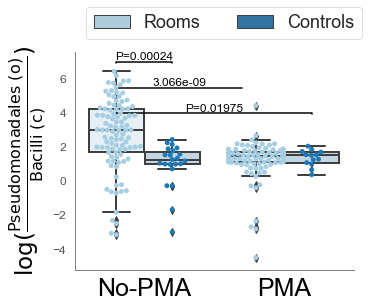

In [15]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 5}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 12


fig, ax = plt.subplots(1,1, figsize=(5,4))

# plot
hueorder = ['Rooms', 'Controls']
order = ['No-PMA','PMA']
pallette = {'Controls':'#1f78b4',
            'Rooms':'#a6cee3'}

ax = swarmbox_plot_hue(lrdf, ax,
                       'log_ratio',
                       'jpl_pma_relabel',
                       'jpl_controltype_0_1_relabel',
                       order,
                       hueorder,
                       palette=pallette)

ax.set_ylabel('$\\log(\\frac{\\mathrm{%s}}{\\mathrm{%s}})$'
              % ('Pseudomonadales\,\,(o)', 'Bacilli\,\,(c)'),
              fontsize=23, color='black')

# get stats
combo = [('Rooms + No-PMA','Controls + No-PMA'),
         ('Rooms + No-PMA','Rooms + PMA'),
         ('Rooms + No-PMA','Controls + PMA')]
statdf, max_order = pairwise_ttest(lrdf,
                                   'jpl_combined',
                                   'log_ratio',
                                   combinations=combo,
                                   correction=False)
x1 = 0 -.2
# annotate by order
for i1, c1 in enumerate(combo):
    c1 = c1[1]
    # annot x-axis
    x2 = (i1/2 + .2)
    # get label
    label_ = 'Rooms + No-PMA' + ' vs. ' + c1
    if label_ not in statdf.index:
        label_ = 'Rooms + No-PMA' + ' vs. ' + c1
    # get stat
    p_ = statdf.loc[label_, 'P']
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:5] + p_[p_.index('e'):]
    else:
        p_ = 'P=%.5f' % (p_)
    # heights
    y, h, col = max_order[label_] + .5 - (i1*1.5), .05, 'k'
    # plot
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, p_,
            ha='center', va='bottom',
            color=col, fontsize=12)  
# add a legend
#ax.set_ylim(0,600)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:2], labels[:2],
            prop={'size':18}, loc=2, 
            bbox_to_anchor=(0.01, 1.25),
            fancybox=True, framealpha=0.8,ncol=2
            , markerscale=1.1, facecolor="white")

# save the figure to file
plt.savefig('../results/figures/pma-log-ratio.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()